# Data Mining Techniques


## Importing of neccessary libraries


Note use python 3.11.7 for stability


In [54]:
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import apyori
from mlxtend.frequent_patterns import apriori, association_rules    
import pycaret
import seaborn as sns
from sklearn.cluster import KMeans
from mlxtend.frequent_patterns import fpgrowth
from mlxtend.frequent_patterns import association_rules
from sklearn.tree import DecisionTreeClassifier, export_text
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score


# Here i am getting the data set

In [39]:
# Load the data
df1 = pd.read_csv('bank marketing dataset 1.csv')
df2 = pd.read_csv('bank marketinf data set 2.csv')

# Split the single column into multiple columns
df1 = df1['age;job;marital;education;default;housing;loan;contact;month;day_of_week;duration;campaign;pdays;previous;poutcome;y'].str.split(';', expand=True)
df2 = df2['age;job;marital;education;default;balance;housing;loan;contact;day;month;duration;campaign;pdays;previous;poutcome;y'].str.split(';', expand=True)

# Assign column names
df1.columns = ['age', 'job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'duration', 'campaign', 'pdays', 'previous', 'poutcome', 'y']
df2.columns = ['age', 'job', 'marital', 'education', 'default', 'balance', 'housing', 'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays', 'previous', 'poutcome', 'y']

# Convert appropriate columns to numeric types
df1['age'] = pd.to_numeric(df1['age'], errors='coerce')
df1['duration'] = pd.to_numeric(df1['duration'], errors='coerce')
df1['campaign'] = pd.to_numeric(df1['campaign'], errors='coerce')
df1['pdays'] = pd.to_numeric(df1['pdays'], errors='coerce')
df1['previous'] = pd.to_numeric(df1['previous'], errors='coerce')

df2['age'] = pd.to_numeric(df2['age'], errors='coerce')
df2['balance'] = pd.to_numeric(df2['balance'], errors='coerce')
df2['duration'] = pd.to_numeric(df2['duration'], errors='coerce')
df2['campaign'] = pd.to_numeric(df2['campaign'], errors='coerce')
df2['pdays'] = pd.to_numeric(df2['pdays'], errors='coerce')
df2['previous'] = pd.to_numeric(df2['previous'], errors='coerce')

# Data Shape and Types
print("DataFrame df1 shape:", df1.shape)
print("DataFrame df2 shape:", df2.shape)
print("\nDataFrame df1 data types:\n", df1.dtypes)
print("\nDataFrame df2 data types:\n", df2.dtypes)



DataFrame df1 shape: (41176, 16)
DataFrame df2 shape: (45211, 17)

DataFrame df1 data types:
 age             int64
job            object
marital        object
education      object
default        object
housing        object
loan           object
contact        object
month          object
day_of_week    object
duration        int64
campaign        int64
pdays           int64
previous        int64
poutcome       object
y              object
dtype: object

DataFrame df2 data types:
 age           int64
job          object
marital      object
education    object
default      object
balance       int64
housing      object
loan         object
contact      object
day          object
month        object
duration      int64
campaign      int64
pdays         int64
previous      int64
poutcome     object
y            object
dtype: object


# Discretization of data 


## Here we start with Kmeans Discretization

In [40]:

# Convert 'age' column to numpy array for clustering
ages_df1 = np.array(df1['age']).reshape(-1, 1)
ages_df2 = np.array(df2['age']).reshape(-1, 1)

# Apply KMeans clustering
kmeans = KMeans(n_clusters=3, random_state=42)
df1['age_clusters'] = kmeans.fit_predict(ages_df1)
df2['age_clusters'] = kmeans.fit_predict(ages_df2)

print(df1)
print(df2)


       age          job  marital            education  default housing loan  \
0       56    housemaid  married             basic.4y       no      no   no   
1       57     services  married          high.school  unknown      no   no   
2       37     services  married          high.school       no     yes   no   
3       40       admin.  married             basic.6y       no      no   no   
4       56     services  married          high.school       no      no  yes   
...    ...          ...      ...                  ...      ...     ...  ...   
41171   73      retired  married  professional.course       no     yes   no   
41172   46  blue-collar  married  professional.course       no      no   no   
41173   56      retired  married    university.degree       no     yes   no   
41174   44   technician  married  professional.course       no      no   no   
41175   74      retired  married  professional.course       no     yes   no   

         contact month day_of_week  duration  campa

In [41]:
# Encode categorical columns into numerical values
encoded_df1 = pd.get_dummies(df1[['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'poutcome', 'y']])
encoded_df2 = pd.get_dummies(df2[['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day', 'poutcome', 'y']])

# Convert encoded DataFrame to numpy array for clustering
entire_df1 = encoded_df1.values
entire_df2 = encoded_df2.values

# Apply KMeans clustering
kmeans = KMeans(n_clusters=3, random_state=42)
df1['entire_clusters'] = kmeans.fit_predict(entire_df1)
df2['entire_clusters'] = kmeans.fit_predict(entire_df2)

print(df1)
print(df2)

       age          job  marital            education  default housing loan  \
0       56    housemaid  married             basic.4y       no      no   no   
1       57     services  married          high.school  unknown      no   no   
2       37     services  married          high.school       no     yes   no   
3       40       admin.  married             basic.6y       no      no   no   
4       56     services  married          high.school       no      no  yes   
...    ...          ...      ...                  ...      ...     ...  ...   
41171   73      retired  married  professional.course       no     yes   no   
41172   46  blue-collar  married  professional.course       no      no   no   
41173   56      retired  married    university.degree       no     yes   no   
41174   44   technician  married  professional.course       no      no   no   
41175   74      retired  married  professional.course       no     yes   no   

         contact month day_of_week  duration  campa

## Next We are initializing the FP-Growth


In [42]:
# Convert df1 to a one-hot encoded DataFrame
df1_one_hot = pd.get_dummies(df1, columns=['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'poutcome', 'y'])

# Retain only binary columns for FP-Growth
binary_columns = df1_one_hot.columns[df1_one_hot.isin([0, 1]).all()]  # Select columns with only 0/1 values
df1_binary = df1_one_hot[binary_columns]

# Apply FP-Growth to find frequent itemsets
frequent_itemsets = fpgrowth(df1_binary, min_support=0.5, use_colnames=True)

# Display frequent itemsets
print("Frequent Itemsets:")
print(frequent_itemsets)

# Generate association rules
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.7)

# Display association rules
print("\nAssociation Rules:")
print(rules)


Frequent Itemsets:
     support                                           itemsets
0   1.000000                                           (y_True)
1   0.863391                             (poutcome_nonexistent)
2   0.824218                                          (loan_no)
3   0.791165                                       (default_no)
4   0.605231                                  (marital_married)
5   0.523873                                      (housing_yes)
6   0.634714                                 (contact_cellular)
7   0.863391                     (y_True, poutcome_nonexistent)
8   0.824218                                  (y_True, loan_no)
9   0.711677                    (loan_no, poutcome_nonexistent)
10  0.711677            (y_True, loan_no, poutcome_nonexistent)
11  0.791165                               (default_no, y_True)
12  0.668545                 (default_no, poutcome_nonexistent)
13  0.651787                              (default_no, loan_no)
14  0.668545         

In [43]:
# Convert df2 to a one-hot encoded DataFrame
df2_one_hot = pd.get_dummies(df2, columns=['job', 'marital','balance', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day', 'poutcome', 'y'])

# Retain only binary columns for FP-Growth
binary_columns = df2_one_hot.columns[df2_one_hot.isin([0, 1]).all()]  # Select columns with only 0/1 values
df2_binary = df2_one_hot[binary_columns]

# Apply FP-Growth to find frequent itemsets
frequent_itemsets = fpgrowth(df2_binary, min_support=0.5, use_colnames=True)

# Display frequent itemsets
print("Frequent Itemsets:")
print(frequent_itemsets)

# Generate association rules
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.7)

# Display association rules
print("\nAssociation Rules:")
print(rules)


Frequent Itemsets:
     support                                           itemsets
0   1.000000                                           (y_True)
1   1.000000                                        (loan_True)
2   1.000000                                     (housing_True)
3   1.000000                                     (default_True)
4   0.817478                                 (poutcome_unknown)
..       ...                                                ...
74  0.647741  (housing_True, default_True, contact_cellular,...
75  0.647741  (y_True, housing_True, default_True, contact_c...
76  0.647741  (y_True, default_True, contact_cellular, loan_...
77  0.647741  (y_True, housing_True, contact_cellular, loan_...
78  0.647741  (default_True, y_True, housing_True, contact_c...

[79 rows x 2 columns]

Association Rules:
                          antecedents  \
0                            (y_True)   
1                         (loan_True)   
2                      (housing_True)   
3     

In [44]:
# Ensure no missing values in  column
df1 = df1.dropna(subset=['age','pdays','previous'])
df2 = df2.dropna(subset=['age','pdays','previous'])

# Convert 'age', 'pdays', and 'previous' columns to numpy array for clustering
ages_df1 = np.array(df1[['age', 'pdays', 'previous']])
ages_df2 = np.array(df2[['age', 'pdays', 'previous']])

# Apply KMeans clustering
kmeans = KMeans(n_clusters=3, random_state=42)
df1['age_clusters'] = kmeans.fit_predict(ages_df1)
df2['age_clusters'] = kmeans.fit_predict(ages_df2)

print(df1)
print(df2)

       age          job  marital            education  default housing loan  \
0       56    housemaid  married             basic.4y       no      no   no   
1       57     services  married          high.school  unknown      no   no   
2       37     services  married          high.school       no     yes   no   
3       40       admin.  married             basic.6y       no      no   no   
4       56     services  married          high.school       no      no  yes   
...    ...          ...      ...                  ...      ...     ...  ...   
41171   73      retired  married  professional.course       no     yes   no   
41172   46  blue-collar  married  professional.course       no      no   no   
41173   56      retired  married    university.degree       no     yes   no   
41174   44   technician  married  professional.course       no      no   no   
41175   74      retired  married  professional.course       no     yes   no   

         contact month day_of_week  duration  campa

## Now we create visuals to better understand the data

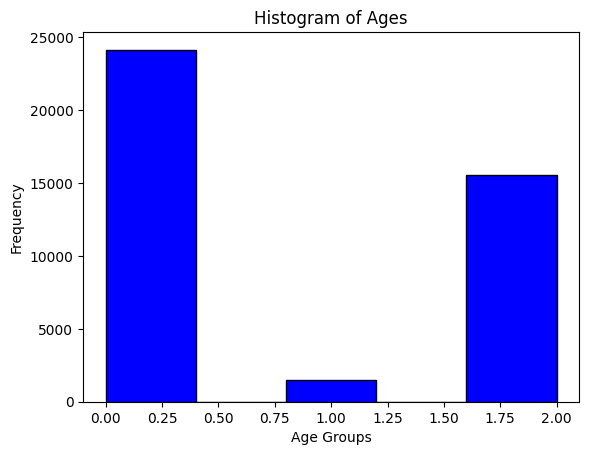

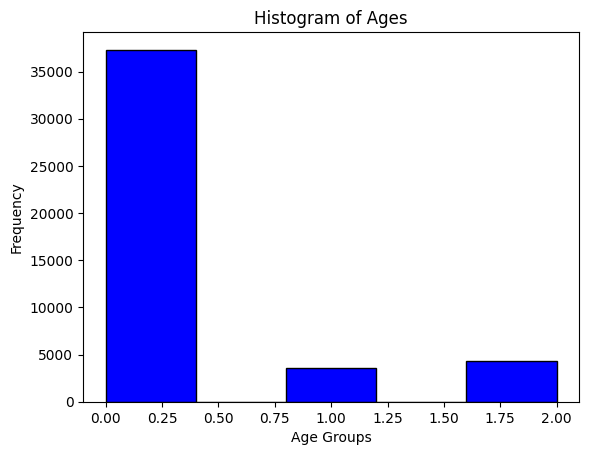

In [45]:
# Create a histogram for the 'age' column
plt.hist(df1['age_clusters'], bins=5, color='blue', edgecolor='black')  # 'bins' controls the number of intervals

# Add labels and title
plt.xlabel('Age Groups')
plt.ylabel('Frequency')
plt.title('Histogram of Ages')

# Show the plot
plt.show()

# Create a histogram for the 'age' column
plt.hist(df2['age_clusters'], bins=5, color='blue', edgecolor='black')  # 'bins' controls the number of intervals

# Add labels and title
plt.xlabel('Age Groups')
plt.ylabel('Frequency')
plt.title('Histogram of Ages')

# Show the plot
plt.show()

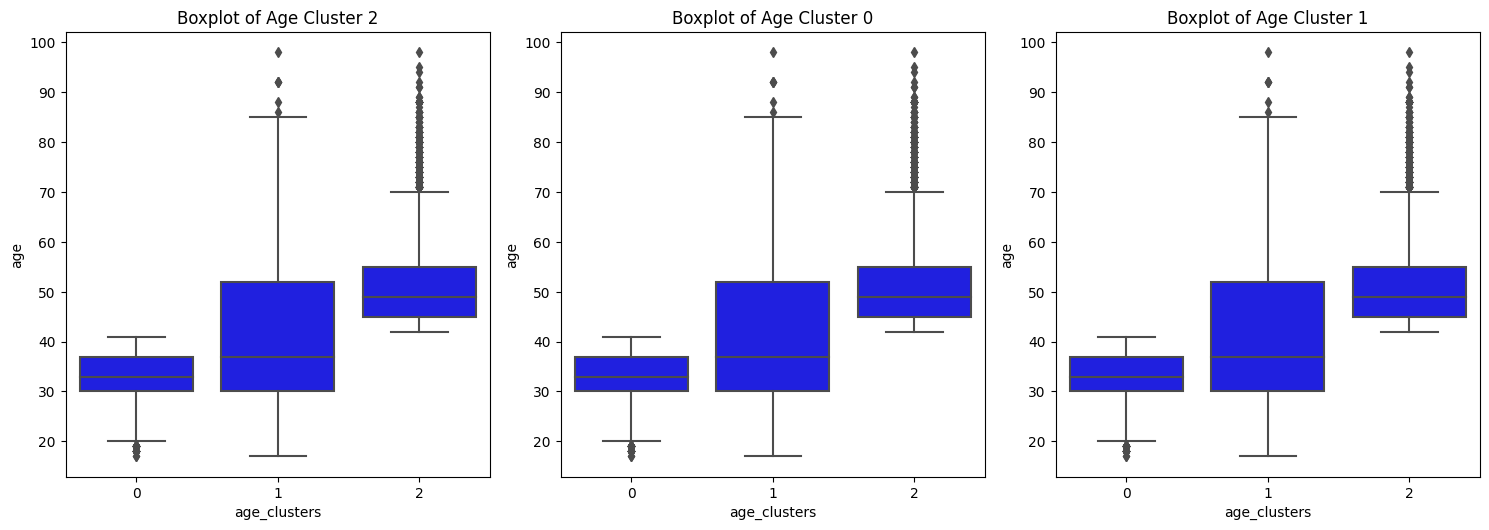

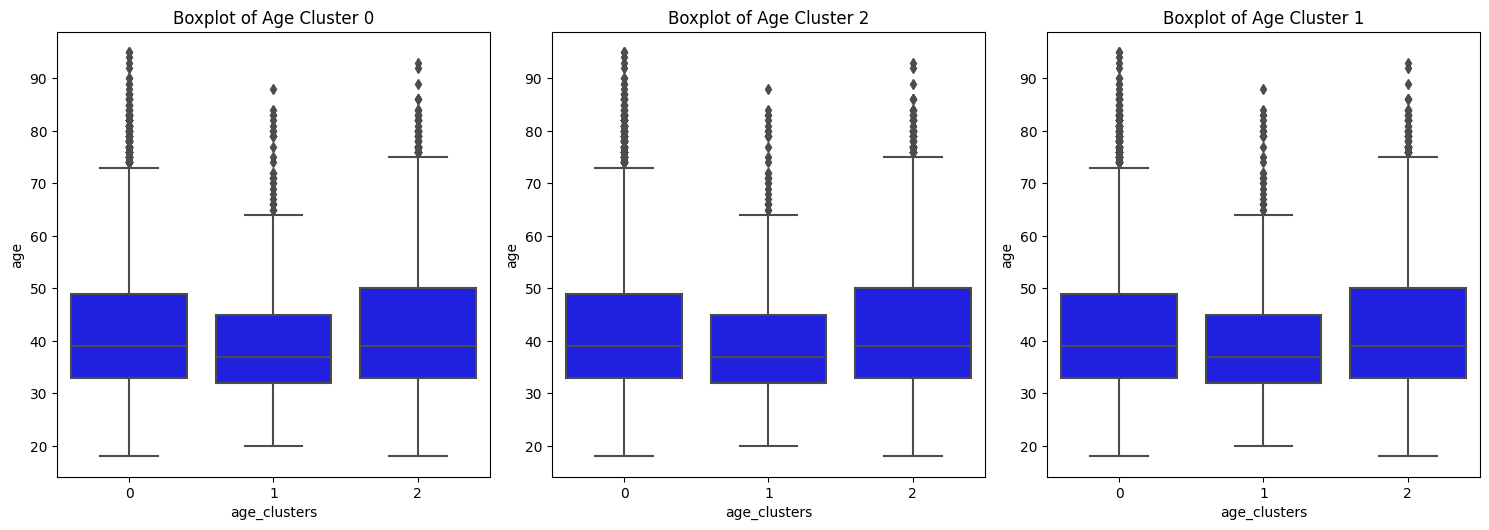

In [46]:
# Create a boxplot for each age cluster
plt.figure(figsize=(15, 10))
for i, col in enumerate(df1['age_clusters'].unique()):  # Iterate over unique age clusters
    plt.subplot(2, 3, i + 1)
    sns.boxplot(x=df1['age_clusters'], y=df1['age'], color='blue')  # Create a boxplot for each cluster
    plt.title(f'Boxplot of Age Cluster {col}')
plt.tight_layout()
plt.show()


# Create a boxplot for each age cluster
plt.figure(figsize=(15, 10))
for i, col in enumerate(df2['age_clusters'].unique()):  # Iterate over unique age clusters
    plt.subplot(2, 3, i + 1)
    sns.boxplot(x=df2['age_clusters'], y=df2['age'], color='blue')  # Create a boxplot for each cluster
    plt.title(f'Boxplot of Age Cluster {col}')
plt.tight_layout()
plt.show()


## From here we shall start to cluster months from the data set.


In [47]:
# Encode 'month' column into numeric values
df1['month_encoded'] = df1['month'].astype('category').cat.codes
df2['month_encoded'] = df2['month'].astype('category').cat.codes

# Convert encoded 'month' column to numpy array for clustering
month_df1 = np.array(df1[['month_encoded']])
month_df2 = np.array(df2[['month_encoded']])

# Apply KMeans clustering
kmeans = KMeans(n_clusters=3, random_state=42)
df1['month_clusters'] = kmeans.fit_predict(month_df1)
df2['month_clusters'] = kmeans.fit_predict(month_df2)

### From here we will be using the cleaned data set to perform data mining techniques
### we create a visuals to show the different months


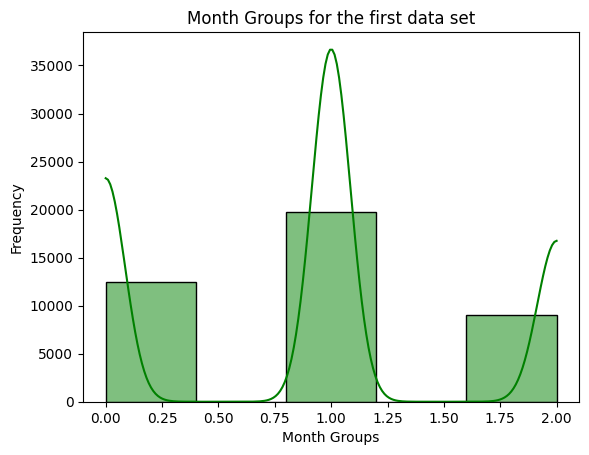

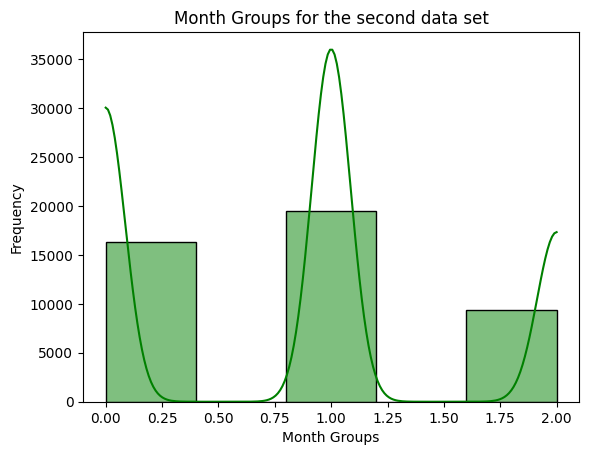

In [48]:
# Create a histogram
sns.histplot(df1['month_clusters'], bins=5, kde=True, color='green')  # 'kde' adds a smooth density curve

# Add labels and title
plt.xlabel('Month Groups')
plt.ylabel('Frequency')
plt.title('Month Groups for the first data set')

# Show the plot
plt.show()


# Create a histogram
sns.histplot(df2['month_clusters'], bins=5, kde=True, color='green')  # 'kde' adds a smooth density curve

# Add labels and title
plt.xlabel('Month Groups')
plt.ylabel('Frequency')
plt.title('Month Groups for the second data set')

# Show the plot
plt.show()


## From her we are going to clustering the data according the balamces

In [49]:
# Convert 'balance' columns to numpy array for clustering
balance_df2 = np.array(df2[['balance']])

# Apply KMeans clustering
kmeans = KMeans(n_clusters=3, random_state=42)
df2['balance_clusters'] = kmeans.fit_predict(balance_df2)

### Then again we are going to visualize the data

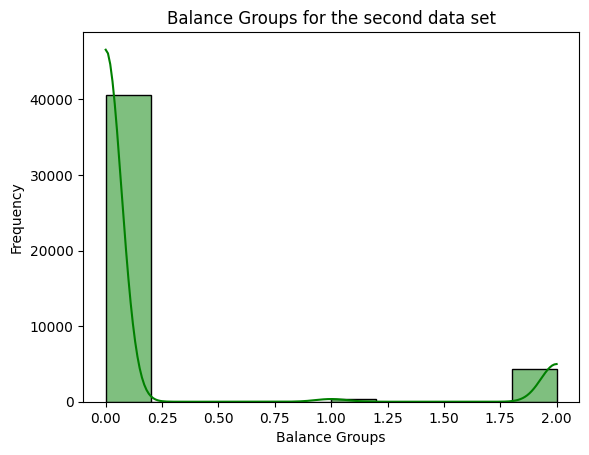

In [50]:
# Create a histogram
sns.histplot(df2['balance_clusters'], bins=10, kde=True, color='green', line_kws={'color': 'blue'})  # 'line_kws' changes the color of the density curve

# Add labels and title
plt.xlabel('Balance Groups')
plt.ylabel('Frequency')
plt.title('Balance Groups for the second data set')

# Show the plot
plt.show()

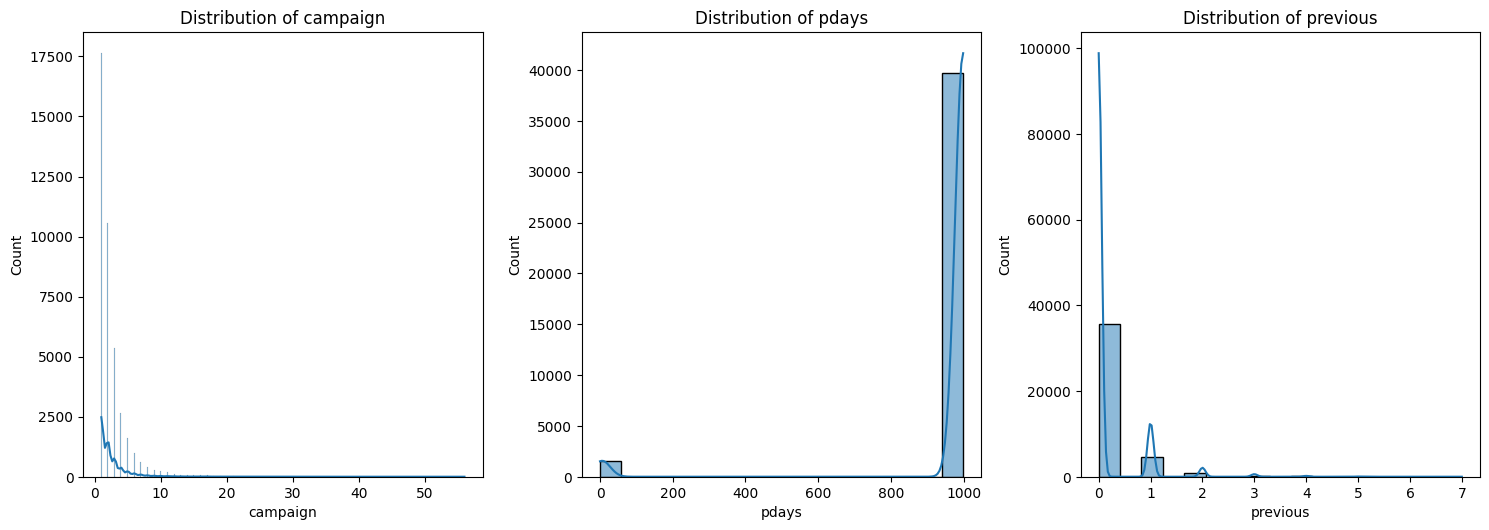

In [51]:
# Numerical features
numerical_features = df1_one_hot[[ 'campaign', 'pdays', 'previous']]

plt.figure(figsize=(15, 10))
for i, col in enumerate(numerical_features):
    plt.subplot(2, 3, i + 1)
    sns.histplot(df1_one_hot[col], kde=True)
    plt.title(f'Distribution of {col}')
plt.tight_layout()
plt.show()

## Here i want to analyze relationships in the data set

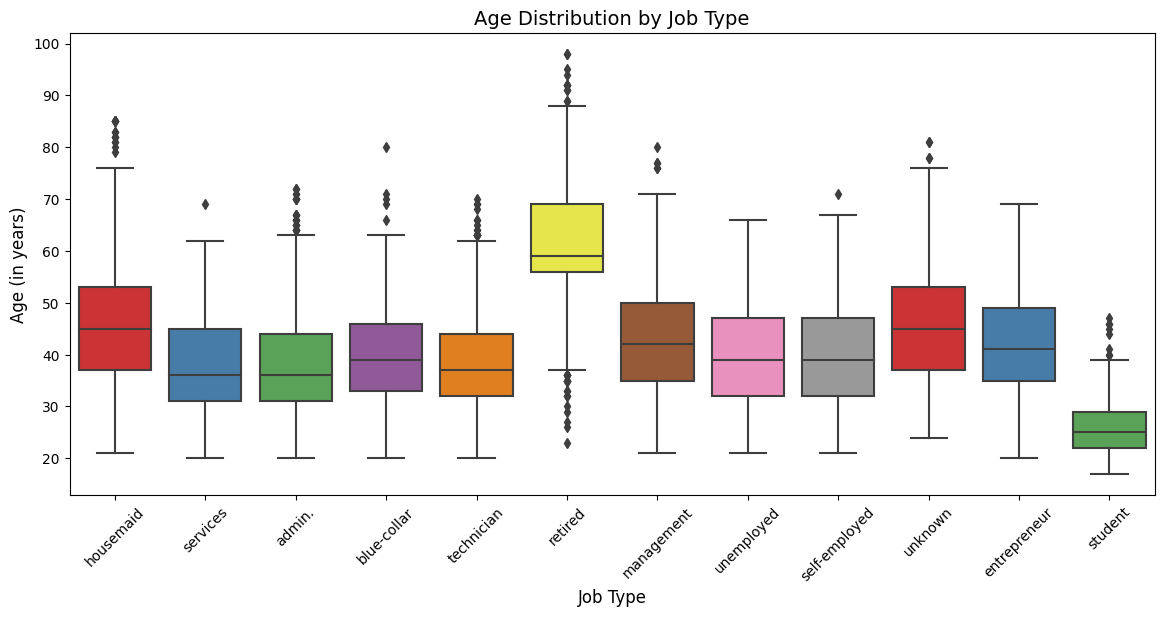

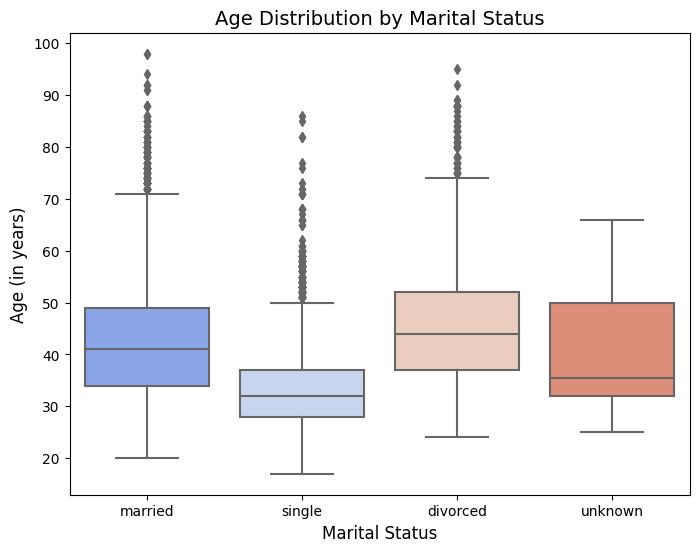

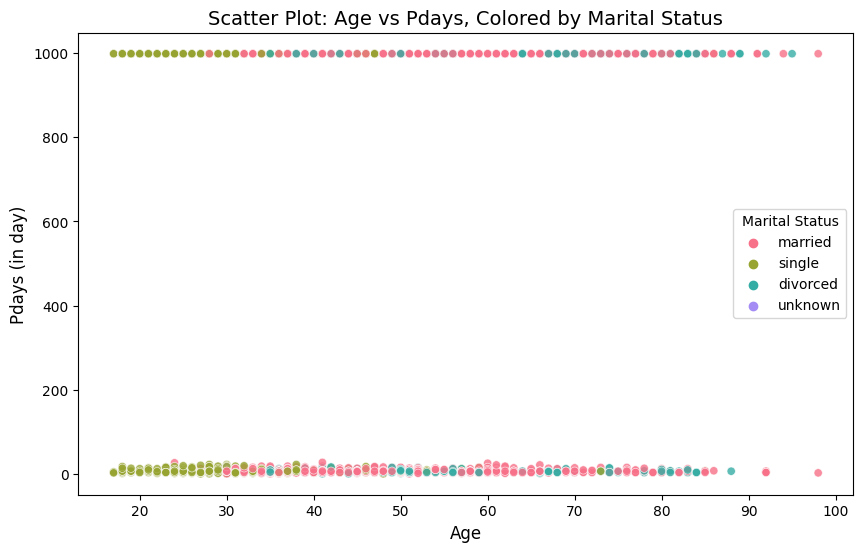

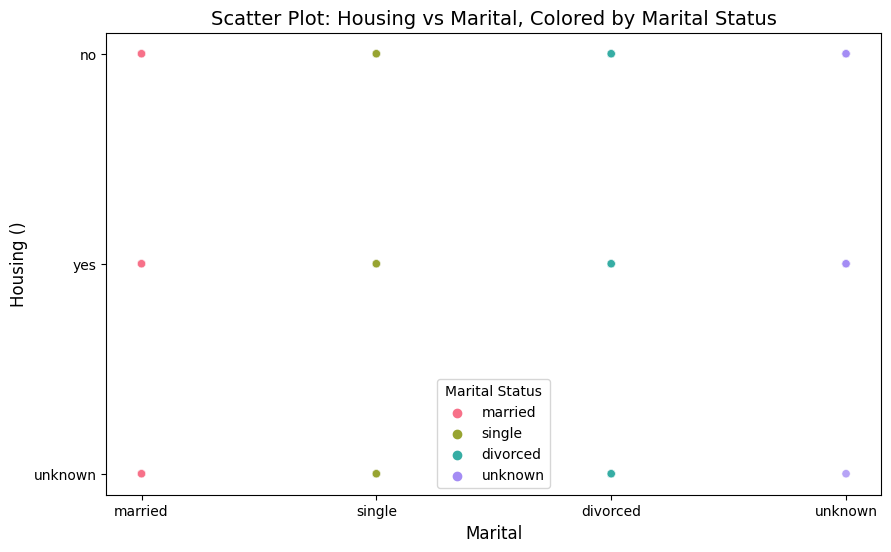

In [55]:
# 1. Boxplot of Balance by Job Type
plt.figure(figsize=(14, 6))
sns.boxplot(x='job', y='age', data=df1, palette='Set1')
plt.xticks(rotation=45)
plt.xlabel('Job Type', fontsize=12)
plt.ylabel('Age (in years)', fontsize=12)
plt.title('Age Distribution by Job Type', fontsize=14)
plt.show()

# 2. Boxplot of Balance by Marital Status
plt.figure(figsize=(8, 6))
sns.boxplot(x='marital', y='age', data=df1, palette='coolwarm')
plt.xlabel('Marital Status', fontsize=12)
plt.ylabel('Age (in years)', fontsize=12)
plt.title('Age Distribution by Marital Status', fontsize=14)
plt.show()

# 3. Scatter Plot of Age vs Balance
plt.figure(figsize=(10, 6))
sns.scatterplot(x='age', y='pdays', data=df1, hue='marital', palette='husl', alpha=0.8)
plt.xlabel('Age', fontsize=12)
plt.ylabel('Pdays (in day)', fontsize=12)
plt.title('Scatter Plot: Age vs Pdays, Colored by Marital Status', fontsize=14)
plt.legend(title='Marital Status')
plt.show()


# 4. Scatter Plot of Marraige vs housing
plt.figure(figsize=(10, 6))
sns.scatterplot(x='marital', y='housing', data=df1, hue='marital', palette='husl', alpha=0.8)
plt.xlabel('Marital', fontsize=12)
plt.ylabel('Housing ()', fontsize=12)
plt.title('Scatter Plot: Housing vs Marital, Colored by Marital Status', fontsize=14)
plt.legend(title='Marital Status')
plt.show()

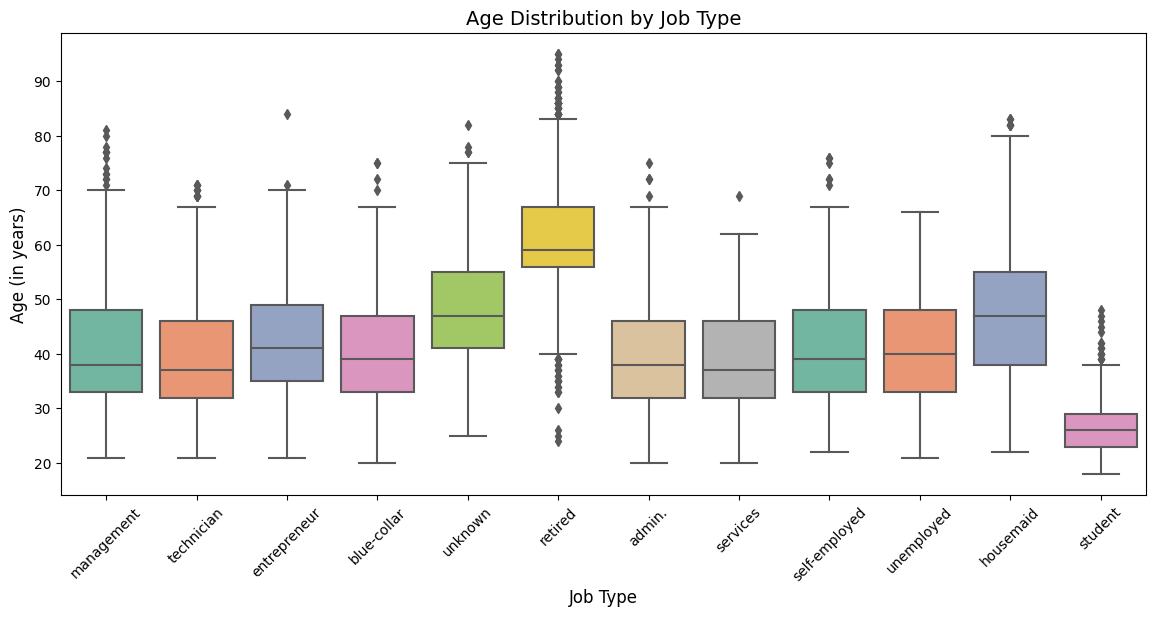

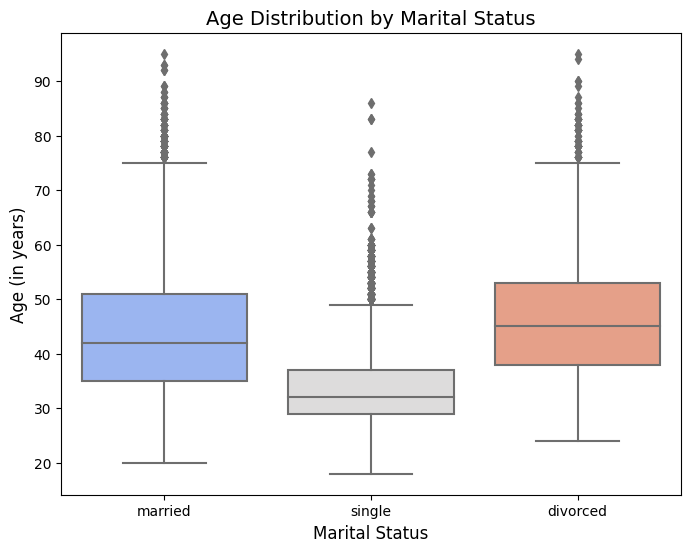

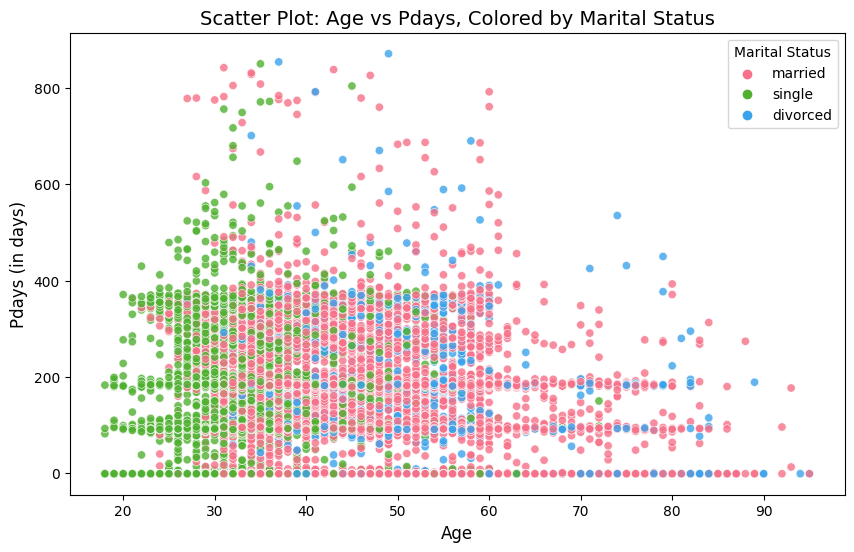

In [ ]:

# 1. Boxplot of Balance by Job Type
plt.figure(figsize=(14, 6))
sns.boxplot(x='job', y='age', data=df2, palette='Set2')
plt.xticks(rotation=45)
plt.xlabel('Job Type', fontsize=12)
plt.ylabel('Age (in years)', fontsize=12)
plt.title('Age Distribution by Job Type', fontsize=14)
plt.show()

# 3. Boxplot of Balance by Marital Status
plt.figure(figsize=(8, 6))
sns.boxplot(x='marital', y='age', data=df2, palette='coolwarm')
plt.xlabel('Marital Status', fontsize=12)
plt.ylabel('Age (in years)', fontsize=12)
plt.title('Age Distribution by Marital Status', fontsize=14)
plt.show()

# 4. Scatter Plot of Age vs Pdays
plt.figure(figsize=(10, 6))
sns.scatterplot(x='age', y='pdays', data=df2, hue='marital', palette='husl', alpha=0.8)
plt.xlabel('Age', fontsize=12)
plt.ylabel('Pdays (in days)', fontsize=12)
plt.title('Scatter Plot: Age vs Pdays, Colored by Marital Status', fontsize=14)
plt.legend(title='Marital Status')
plt.show()


## Here we are going use a decision tree to further analyze the data

In [57]:
# Features and target variable
X = df1[['age', 'job', 'pdays','poutcome','y','campaign','previous']]  # Independent variables
y = df1['y']  # Dependent variable

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Initialize the Decision Tree Classifier
clf = DecisionTreeClassifier(max_depth=3, random_state=42)

# Train the model
clf.fit(X_train, y_train)

# Predict on the test set
y_pred = clf.predict(X_test)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

# Visualize the Decision Tree
plt.figure(figsize=(12, 8))
plot_tree(clf, feature_names=X.columns, class_names=['No', 'Yes'], filled=True)
plt.title("Decision Tree Visualization")
plt.show()

ValueError: could not convert string to float: 'entrepreneur'